# **1. 데이터 세팅**

데이터 출처 : http://know.tour.go.kr (관광정보시스템)

* 2018-2019년 자료
* 총 응답자(N) : 34,746명

###Data Describe

* ID 아이디

* SMONTH 여행 시작 월
* S_Day 여행일수(박)
* TCOST 여행 총경비
* TNUM 여행 인원
* ONE_TCOST 1인 지출비용
* CASE 여행유형
* SPOT 1번째 여행 1번째 방문지
---
* AG 여행사상품구매여부
* AGTYPE 여행사 상품 종류 (전체/부분)
* A2_1~3 여행지선택 이유 1-3순위
* A7B 동반자 유형
---
* PRE_TOTAL 여행전 지출 총합_1인
* NA10A 여행사 지출비용_1인
* NA10C 숙박비_1인
* NA10D 식비_1인
* NA10E 교통비_1인
* NA10F 여행활동비_1인
* NA10G 쇼핑비_1인
* NA10_TOTAL 여행지 지출 총합_1인
---
* RATING 전반적 만족도
* A13 재방문 의도
* A14 타인추천의도
---
* DQ5 월평균 가구 소득
* DQ6 월평균 본인 소득
* SEX 성별
* BAGE 연령대
* BARA 거주지역

In [1]:
%%capture
import sys

if 'google.colab' in sys.modules:
    !pip install category_encoders==2.*
    !pip install eli5
    !pip install pdpbox
    !pip install shap
!conda install -c conda-forge shap

## **raw data**

In [3]:
!git clone https://github.com/kerobes97/Lets_Boot.git

Cloning into 'Lets_Boot'...
remote: Enumerating objects: 120, done.
remote: Counting objects: 100% (120/120), done.
remote: Compressing objects: 100% (109/109), done.
Receiving objects: 100% (120/120), 37.76 MiB | 15.50 MiB/s, done.
remote: Total 120 (delta 47), reused 0 (delta 0), pack-reused 0
Resolving deltas: 100% (47/47), done.


In [4]:
!ls /content/Lets_Boot/Travel_Data/Datasets

 2018_국민여행조사_국내여행.xlsx  'Data Describe'
 2019_국민여행조사_국내여행.xlsx


In [2]:
import pandas as pd

df18 = pd.read_excel('/content/Lets_Boot/Travel_Data/Datasets/2018 국민여행조사_국내여행.xlsx')
df19 = pd.read_excel('/content/Lets_Boot/Travel_Data/Datasets/2019 국민여행조사_국내여행.xlsx') 
df18.shape,  df19.shape

((24154, 43), (48269, 38))

## **1-1 raw data  전처리**

In [3]:
# #만족도 조사가 완료된 데이터만 사용
# 하려했으나 -> 편향이 너어어어무 심해서 안그러기로

# df18=df18.dropna(subset=['RATING'])
# df19=df19.dropna(subset=['RATING'])

In [4]:
#18년도 데이터 S_Day
df18['start'] = pd.to_datetime(dict(year=df18.D_TRA1_SYEAR, month=df18.D_TRA1_SMONTH, day=df18.D_TRA1_SDAY))
df18['end'] = pd.to_datetime(dict(year=df18.D_TRA1_EYEAR, month=df18.D_TRA1_EMONTH, day=df18.D_TRA1_EDAY))

df18['S_Day']= (df18['end'] - df18['start']).dt.days
df18.head(10)

,ID,MON_EXP_DOM_TOUR,MON_EXP_DOM_BUSIN,MON_EXP_DOM_FRI,D_TRA1_SYEAR,D_TRA1_SMONTH,D_TRA1_SDAY,D_TRA1_EYEAR,D_TRA1_EMONTH,D_TRA1_EDAY,TNUM,ONE_TCOST,CASE,SPOT,AG,AGTYPE,A2_1,A2_2,A2_3,A7B_1,A7B_2,A7B_3,A7B_4,A7B_5,A7B_6,PRE_TOTAL,NA10A,NA10C,NA10D,NA10E,NA10F,NA10G,NA_TOTAL,RATING,A13,A14,DQ5,DQ6,SEX,BAGE,BARA,EXP_NIGHT,EXP_ADAY,start,end,S_Day
0,11010560291_702520,2,2,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,12,9,1,3,11,0,0,NaT,NaT,NaN
1,11010560291_702521,2,2,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,12,6,2,4,11,0,0,NaT,NaT,NaN
2,11010560291_702526,2,2,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,12,99,2,2,11,0,0,NaT,NaT,NaN
3,11010560291_702539,1,2,2,2018.0,7.0,6.0,2018.0,7.0,8.0,5.0,360000.0,2.0,39.0,2.0,NaN,5.0,3.0,2.0,NaN,NaN,3.0,NaN,NaN,NaN,0.0,0.0,55214.723926,123680.981595,149079.754601,5521.472393,26503.067485,360000.0,4.0,5.0,4.0,12,99,2,6,11,1,0,2018-07-06,2018-07-08,2.0
4,11010560291_702558,2,2,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,10,7,1,5,11,0,0,NaT,NaT,NaN
5,11010560321_500005,1,2,2,2018.0,5.0,19.0,2018.0,5.0,19.0,33.0,57200.0,2.0,34.0,2.0,NaN,2.0,14.0,NaN,NaN,NaN,NaN,NaN,5.0,NaN,0.0,0.0,0.000000,4200.000000,10000.000000,3000.000000,10000.000000,57200.0,4.0,4.0,3.0,10,5,2,5,11,0,1,2018-05-19,2018-05-19,0.0
6,11010560321_500010,1,2,2,2018.0,5.0,8.0,2018.0,5.0,8.0,5.0,90000.0,2.0,31.0,2.0,NaN,12.0,4.0,14.0,NaN,NaN,3.0,NaN,NaN,NaN,0.0,0.0,0.000000,51373.390558,7725.321888,11587.982833,19313.304721,90000.0,4.0,4.0,4.0,8,8,1,7,11,0,1,2018-05-08,2018-05-08,0.0
7,11010560321_500015,2,2,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8,99,1,1,11,0,0,NaT,NaT,NaN
8,11010560321_500023,2,2,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6,6,1,3,11,0,0,NaT,NaT,NaN
9,11010560321_500029,1,2,2,2018.0,5.0,4.0,2018.0,5.0,6.0,5.0,68500.0,2.0,35.0,2.0,NaN,5.0,4.0,8.0,1.0,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.000000,44500.000000,24000.000000,0.000000,0.000000,68500.0,4.0,4.0,3.0,4,4,2,6,11,1,0,2018-05-04,2018-05-06,2.0


In [5]:
#18년도 여행 안간사람 제외
df18=df18[~df18['CASE'].isnull()]

#19년도 여행 안간사람 제외
df19=df19[~df19['CASE'].isnull()]

In [6]:
#18년도 TCOST
df18['TCOST']= df18['TNUM '] * df18['ONE_TCOST']

In [7]:
#여행유형 확인
df18['CASE'].unique(), df19['CASE'].unique()

(array([2., 4., 3.]), array([1., 5., 3., 4., 2.]))

In [8]:
#여행유형 통일
def case18(row):
  if row['CASE']==2:
    return 'trip'
  elif row['CASE']==3:
    return 'work'
  elif row['CASE']==4:
    return 'family'

def case19(row):
  if row['CASE']==1:
    return 'trip'
  elif row['CASE']==2:
    return 'trip'
  elif row['CASE']==3:
    return 'family'
  elif row['CASE']==4:
    return 'work'
  elif row['CASE']==5:
    return 'work'


df18['CASE'] = df18.apply(lambda row: case18(row), axis=1)
df19['CASE'] = df19.apply(lambda row: case19(row), axis=1)

df18['CASE'].unique(), df19['CASE'].unique()

(array(['trip', 'family', 'work'], dtype=object),
 array(['trip', 'work', 'family'], dtype=object))

In [9]:
#도시 번호 등록
df19['SPOT'] = df19['SPOT']//1000

df19['SPOT'].unique()

array([21., 36., 31., 39., 22., 32., 37., 25., 23., 34., 38., 35., 33.,
       24., 26., 29., 11.])

In [10]:
df18.columns.unique(), df19.columns.unique()

(Index(['ID', 'MON_EXP_DOM_TOUR', 'MON_EXP_DOM_BUSIN', 'MON_EXP_DOM_FRI',
        'D_TRA1_SYEAR', 'D_TRA1_SMONTH', 'D_TRA1_SDAY', 'D_TRA1_EYEAR',
        'D_TRA1_EMONTH', 'D_TRA1_EDAY', 'TNUM ', 'ONE_TCOST', 'CASE', 'SPOT',
        'AG', 'AGTYPE', 'A2_1', 'A2_2', 'A2_3', 'A7B_1', 'A7B_2', 'A7B_3',
        'A7B_4', 'A7B_5', 'A7B_6', 'PRE_TOTAL', 'NA10A', 'NA10C', 'NA10D',
        'NA10E', 'NA10F', 'NA10G', 'NA_TOTAL', 'RATING', 'A13', 'A14', 'DQ5',
        'DQ6', 'SEX', 'BAGE', 'BARA', 'EXP_NIGHT', 'EXP_ADAY', 'start', 'end',
        'S_Day', 'TCOST'],
       dtype='object'),
 Index(['ID', 'Q', 'SMONTH', 'S_Day', 'TCOST', 'TNUM', 'ONE_TCOST', 'CASE',
        'SPOT', 'AG', 'AGTYPE', 'A2_1', 'A2_2', 'A2_3', 'A7B_1', 'A7B_2',
        'A7B_3', 'A7B_4', 'A7B_5', 'A7B_6', 'PRE_TOTAL', 'NA10A', 'NA10C',
        'NA10D', 'NA10E', 'NA10F', 'NA10G', 'NA_TOTAL', 'RATING', 'A13', 'A14',
        'DQ5', 'DQ6', 'SEX', 'BAGE', 'BARA', 'EXP_NIGHT', 'EXP_ADAY'],
       dtype='object'))

In [11]:
#데이터 피쳐명 통일
df18=df18[['ID', 'D_TRA1_SMONTH', 'S_Day', 'TCOST', 'TNUM ', 'ONE_TCOST', 'CASE', 'SPOT',
          'A2_1', 'A2_2', 'A2_3', 'A7B_1', 'A7B_2', 'A7B_3', 'A7B_4', 'A7B_5', 'A7B_6',
          'PRE_TOTAL', 'NA10A', 'NA10C', 'NA10D', 'NA10E', 'NA10F', 'NA10G', 'NA_TOTAL', 
          'RATING', 'A13', 'A14', 'DQ5', 'DQ6', 'SEX', 'BAGE', 'BARA',
          'EXP_NIGHT', 'EXP_ADAY']]
df18.rename(columns = {'D_TRA1_SMONTH':'SMONTH', 'TNUM ':'TNUM'}, inplace = True)

df19=df19[['ID', 'SMONTH', 'S_Day', 'TCOST', 'TNUM', 'ONE_TCOST', 'CASE','SPOT', 
          'A2_1', 'A2_2', 'A2_3',  'A7B_1', 'A7B_2', 'A7B_3', 'A7B_4', 'A7B_5', 'A7B_6', 
          'PRE_TOTAL', 'NA10A', 'NA10C', 'NA10D', 'NA10E', 'NA10F', 'NA10G', 'NA_TOTAL', 
          'RATING', 'A13', 'A14', 'DQ5', 'DQ6', 'SEX', 'BAGE', 'BARA', 
          'EXP_NIGHT', 'EXP_ADAY']]

## **1-2 df data 전처리**

In [33]:
df=pd.concat([df18, df19])
# df.head()
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 41624 entries, 3 to 48267
Data columns (total 35 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   ID         41624 non-null  object 
 1   SMONTH     41624 non-null  float64
 2   S_Day      41624 non-null  float64
 3   TCOST      39138 non-null  float64
 4   TNUM       39138 non-null  float64
 5   ONE_TCOST  41624 non-null  float64
 6   CASE       41624 non-null  object 
 7   SPOT       41624 non-null  float64
 8   A2_1       34615 non-null  float64
 9   A2_2       31595 non-null  float64
 10  A2_3       23594 non-null  float64
 11  A7B_1      18364 non-null  float64
 12  A7B_2      970 non-null    float64
 13  A7B_3      12359 non-null  float64
 14  A7B_4      775 non-null    float64
 15  A7B_5      2039 non-null   float64
 16  A7B_6      117 non-null    float64
 17  PRE_TOTAL  34615 non-null  float64
 18  NA10A      34615 non-null  float64
 19  NA10C      34615 non-null  float64
 20  NA10D 

In [34]:
df['CASE'].unique()

array(['trip', 'family', 'work'], dtype=object)

In [35]:
#중복값
df[df.duplicated()==True]

df=df.reset_index(drop=True)
df[df.index.duplicated()==True]

,ID,SMONTH,S_Day,TCOST,TNUM,ONE_TCOST,CASE,SPOT,A2_1,A2_2,A2_3,A7B_1,A7B_2,A7B_3,A7B_4,A7B_5,A7B_6,PRE_TOTAL,NA10A,NA10C,NA10D,NA10E,NA10F,NA10G,NA_TOTAL,RATING,A13,A14,DQ5,DQ6,SEX,BAGE,BARA,EXP_NIGHT,EXP_ADAY


In [36]:
#동행 유형 생성
def A7B (row):
  if row['A7B_1']==1:
    return 'Fam'
  elif row['A7B_2']==2:
    return 'B_Fam'
  elif row['A7B_3']==3:
    return 'Mate'
  elif (row['A7B_4']==4) & (row['A7B_6']==6):
    return 'Co'
  elif row['A7B_5']==5:
    return 'Crew'
  else:
    return 'Etc'

df['A7B'] = df.apply(lambda row: A7B(row), axis=1)
# df[df['A7B'].isnull()]
df['A7B'].unique()

array(['Mate', 'Crew', 'Fam', 'Etc', 'B_Fam'], dtype=object)

In [37]:
#여행 총지출 범주 생성
df['M_TOTAL']=df['PRE_TOTAL']+df['NA_TOTAL']
df['M_TOTAL']=df['M_TOTAL'].fillna(df['ONE_TCOST'])
df['M_TOTAL'].isnull().sum()
def money (row):
  if (row['M_TOTAL']>0) & (row['M_TOTAL']<=30000):
    return 1
  elif (row['M_TOTAL']>30000) & (row['M_TOTAL']<=50000):
    return 2
  elif (row['M_TOTAL']>50000) & (row['M_TOTAL']<=80000):
    return 3
  elif (row['M_TOTAL']>80000) & (row['M_TOTAL']<=110000):
    return 4
  elif (row['M_TOTAL']>110000) & (row['M_TOTAL']<=150000):
    return 5
  elif (row['M_TOTAL']>150000) & (row['M_TOTAL']<=200000):
    return 6
  elif (row['M_TOTAL']>200000) & (row['M_TOTAL']<=300000):
    return 7
  elif (row['M_TOTAL']>300000):
    return 8

df['BNA'] = df.apply(lambda row: money(row), axis=1)
# df[df['BNA'].isnull()]
df=df[~df['BNA'].isnull()]
df['BNA'].unique()

array([8., 3., 4., 5., 2., 6., 7., 1.])

In [38]:
df['BNA'].value_counts()

3.0    7642
2.0    7510
4.0    6801
5.0    4923
6.0    4417
1.0    4128
7.0    3496
8.0    2704
Name: BNA, dtype: int64

In [39]:
#숙박 여부 생성
def DnN (row):
  if row['EXP_NIGHT']==1:
    return 1
  elif row['EXP_ADAY']==1:
    return 0

df['DandN'] = df.apply(lambda row: DnN(row), axis=1)
df['DandN'].unique()

array([1, 0])

In [40]:
# import numpy as np
# df['A2_1'] = df['A2_1'].replace(np.nan, '', regex=True)

# df['A2_1'] = pd.to_numeric(df['A2_1'])
# df['A2_1'].dtype

In [41]:
#여행지 선정 이유 생성
def why (row):
  if row['A2_1']==1:
    return 'Famous'
  elif (row['A2_1']==2) or (row['A2_1']==6):
    return 'View'
  elif row['A2_1']==3:
    return 'Budget'
  elif (row['A2_1']==4) or (row['A2_1']==5) or (row['A2_1']==9):
    return 'Time/Trans'
  elif row['A2_1']==7:
    return 'Shopping'
  elif row['A2_1']==8:
    return 'Food'
  elif (row['A2_1']==10) or (row['A2_1']==13) or (row['A2_1']==9):
    return 'Edu'
  elif (row['A2_1']==11) or (row['A2_1']==14):
    return 'Rec'
  elif row['A2_1']==15:
    return 'Conv'
  else: return 'etc'

df['REASON'] = df.apply(lambda row: why(row), axis=1)
# df['REASON'].isnull().sum()
df['REASON'].unique()

array(['Time/Trans', 'View', 'etc', 'Food', 'Rec', 'Famous', 'Budget',
       'Edu', 'Conv', 'Shopping'], dtype=object)

In [42]:
#부산에 온 사람
# df['Busan'] = df['SPOT'] == 21
# df['Busan'].value_counts(normalize=True)

#강원도에 온 사람
df['Gangwon'] = (df['SPOT'] == 32) & (df['CASE'] == 'trip')
df['Gangwon'].value_counts(normalize=True)

False    0.89933
True     0.10067
Name: Gangwon, dtype: float64

In [43]:
#지방 단위 통합
def area (row):
  if (row['SPOT']==11) or (row['SPOT']==23):
    return 'Seo/In'
  elif (row['SPOT']==21) or (row['SPOT']==26):
    return 'Bu/Wul'
  elif (row['SPOT']==22) or (row['SPOT']==37):
    return 'KB/Dae'
  elif (row['SPOT']==24) or (row['SPOT']==36):
    return 'JN/Gwa'
  elif (row['SPOT']==25) or (row['SPOT']==29) or (row['SPOT']==34):
    return 'CN/Dae'
  elif row['SPOT']==31:
    return 'Gyeongi'
  elif row['SPOT']==32:
    return 'Gangwon'
  elif row['SPOT']==33:
    return 'CB'
  elif row['SPOT']==35:
    return 'JB'
  elif row['SPOT']==38:
    return 'KN'
  elif row['SPOT']==39:
    return 'Jeju'

df['SPOT'] = df.apply(lambda row: area(row), axis=1)
df[df['SPOT'].isnull()]
df['SPOT'].unique()

array(['Jeju', 'CN/Dae', 'Gyeongi', 'JB', 'JN/Gwa', 'Gangwon', 'Seo/In',
       'Bu/Wul', 'CB', 'KN', 'KB/Dae'], dtype=object)

In [44]:
df.isnull().sum()

ID               0
SMONTH           0
S_Day            0
TCOST         2486
TNUM          2486
ONE_TCOST        0
CASE             0
SPOT             0
A2_1          7009
A2_2         10028
A2_3         18027
A7B_1        23259
A7B_2        40651
A7B_3        29262
A7B_4        40846
A7B_5        39583
A7B_6        41504
PRE_TOTAL     7009
NA10A         7009
NA10C         7009
NA10D         7009
NA10E         7009
NA10F         7009
NA10G         7009
NA_TOTAL      7009
RATING        7009
A13           7009
A14           7009
DQ5              0
DQ6              0
SEX              0
BAGE             0
BARA             0
EXP_NIGHT        0
EXP_ADAY         0
A7B              0
M_TOTAL          0
BNA              0
DandN            0
REASON           0
Gangwon          0
dtype: int64

In [46]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 41621 entries, 0 to 41623
Data columns (total 41 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   ID         41621 non-null  object 
 1   SMONTH     41621 non-null  float64
 2   S_Day      41621 non-null  float64
 3   TCOST      39135 non-null  float64
 4   TNUM       39135 non-null  float64
 5   ONE_TCOST  41621 non-null  float64
 6   CASE       41621 non-null  object 
 7   SPOT       41621 non-null  object 
 8   A2_1       34612 non-null  float64
 9   A2_2       31593 non-null  float64
 10  A2_3       23594 non-null  float64
 11  A7B_1      18362 non-null  float64
 12  A7B_2      970 non-null    float64
 13  A7B_3      12359 non-null  float64
 14  A7B_4      775 non-null    float64
 15  A7B_5      2038 non-null   float64
 16  A7B_6      117 non-null    float64
 17  PRE_TOTAL  34612 non-null  float64
 18  NA10A      34612 non-null  float64
 19  NA10C      34612 non-null  float64
 20  NA10D 

# **2. EDA**

In [ ]:
df['SPOT'].value_counts()

JN/Gwa     5132
CN/Dae     5090
KB/Dae     4985
Gangwon    4592
Gyeongi    4305
KN         4098
Seo/In     3364
Bu/Wul     3232
JB         3098
CB         1925
Jeju       1800
Name: SPOT, dtype: int64

In [ ]:
#사람들이 가장 자주 찾는 지방
df['SPOT'].mode()

0    JN/Gwa
dtype: object

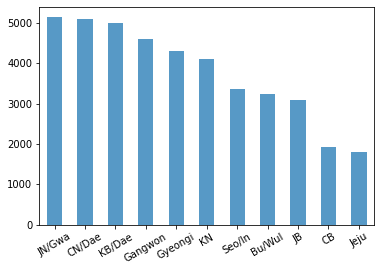

In [ ]:
#사람들이 많이 가는 지방
df['SPOT'].value_counts().plot(kind='bar', alpha=0.75 ,rot=30);

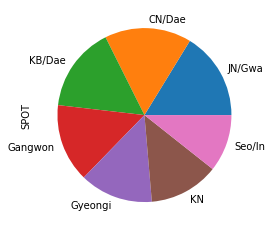

In [ ]:
df['SPOT'].value_counts().head(7).plot(kind='pie');

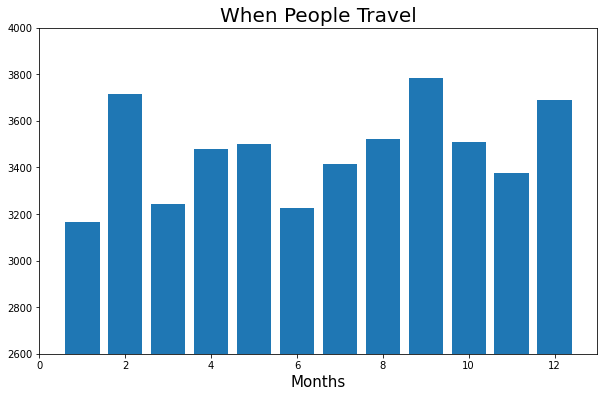

In [ ]:
#사람들이 여행을 많이 가는 월
df['SMONTH'].value_counts().head(5)

smonth = df['SMONTH'].value_counts().sort_index()

import matplotlib.pyplot as plt
import seaborn as sns

plt.rcParams['figure.figsize'] = [10, 6]

plt.bar(smonth.index, smonth)
plt.title('When People Travel', fontsize=20)
plt.xlabel('Months', fontsize=15)
plt.xlim(0,13)
plt.ylim(2600, 4000)
plt.show()

In [ ]:
df_dn=pd.crosstab(index=df['DandN'], columns=df['SPOT'])
df_dn

SPOT,Bu/Wul,CB,CN/Dae,Gangwon,Gyeongi,JB,JN/Gwa,Jeju,KB/Dae,KN,Seo/In
DandN,,,,,,,,,,,
0,1434,1029,2926,1370,2715,1844,2651,240,2763,2188,1832
1,1798,896,2164,3222,1590,1254,2481,1560,2222,1910,1532


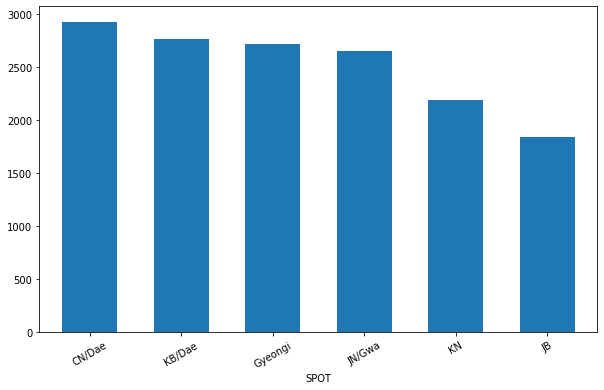

In [ ]:
#당일치기 인기지역 TOP5
df_d = df_dn.loc[0].sort_values(ascending=False).head(6)

plt.rcParams['figure.figsize'] = [10, 6]
ax = df_d.plot.bar(width = 0.6, stacked=False, rot=30)

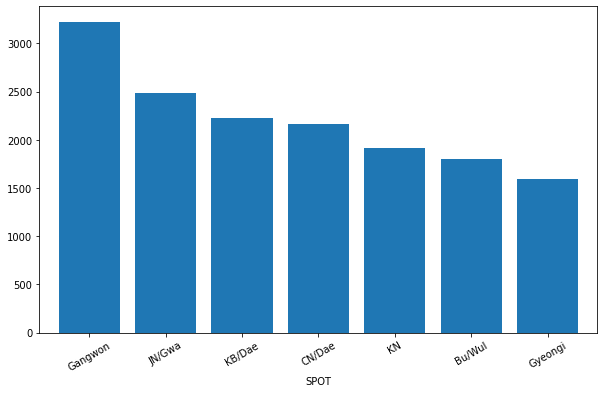

In [ ]:
#1박이상 인기지역 TOP5
df_n =  df_dn.loc[1].sort_values(ascending=False).head(7)

ax = df_n.plot.bar(width = 0.8, stacked=False, rot=30)

In [ ]:
df.groupby('SPOT')['M_TOTAL'].agg(['min','max','mean','median'])

,min,max,mean,median
SPOT,,,,
Bu/Wul,4000.0,1275000.0,141758.134412,100000.0
CB,3750.0,875000.0,98621.315844,75000.0
CN/Dae,5000.0,1127500.0,95467.880157,74500.0
Gangwon,3000.0,1300000.0,151990.877178,133750.0
Gyeongi,4000.0,1300000.0,92080.048780,70000.0
JB,5000.0,975000.0,98416.720077,80000.0
JN/Gwa,3333.0,1430000.0,114787.786763,90000.0
Jeju,3330.0,1800000.0,391276.437593,370000.0
KB/Dae,2500.0,1060000.0,103683.719057,75000.0


In [ ]:
df['M_TOTAL'].agg(['min','max','mean','median'])

min       2.500000e+03
max       2.795000e+06
mean      1.249476e+05
median    9.000000e+04
Name: M_TOTAL, dtype: float64

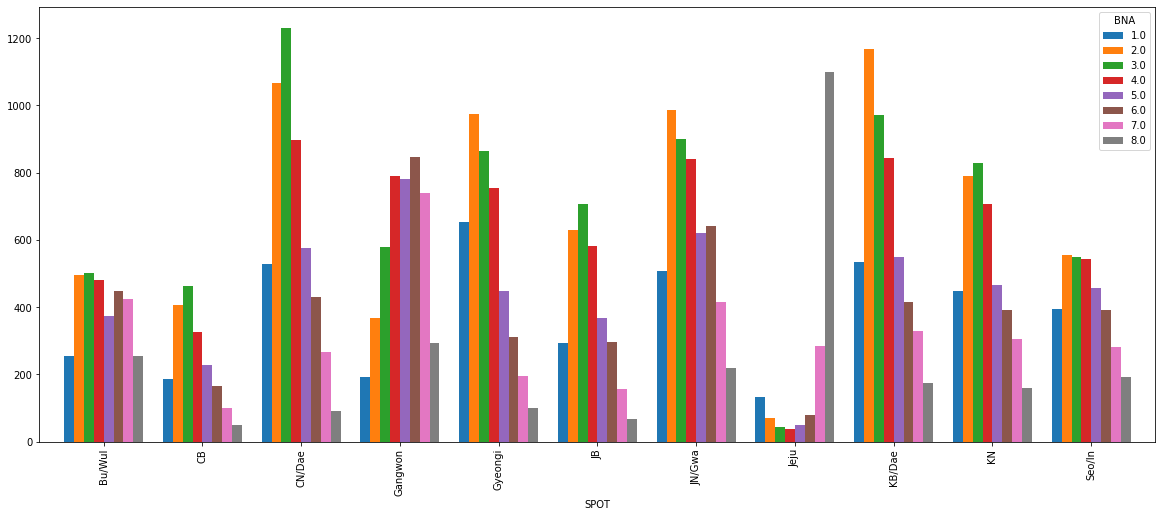

In [ ]:
#여행객의 지출이 가장 큰 도시
money = pd.crosstab(index=df['SPOT'], columns=df['BNA'], aggfunc=None)
# money = money.rename_axis(None, axis=1)
# money = money.rename_axis(None, axis=0)
money

plt.rcParams['figure.figsize'] = [20, 8]
ax = money.plot.bar(width = 0.8, stacked=False)

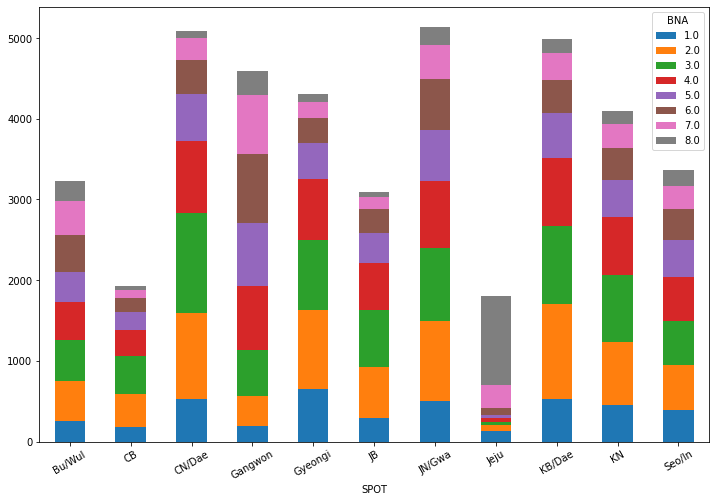

In [ ]:
plt.rcParams['figure.figsize'] = [12, 8]
ax = money.plot.bar(width = 0.5, stacked=True, rot=30)

In [ ]:
#사람들이 여행가는 이유
df['REASON'].value_counts()

etc           8115
View          7883
Time/Trans    7770
Famous        5928
Rec           5283
Food          3154
Budget        1854
Edu            704
Shopping       513
Conv           417
Name: REASON, dtype: int64

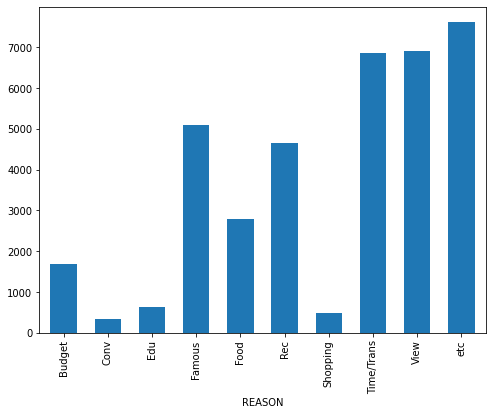

In [ ]:
#강원도 여행 이유
reason = pd.crosstab((df['SPOT']=='Gangwon'), df['REASON'])
reason

plt.rcParams['figure.figsize'] = [8, 6]
ax = reason.iloc[0].plot.bar(width = 0.6, stacked=True)

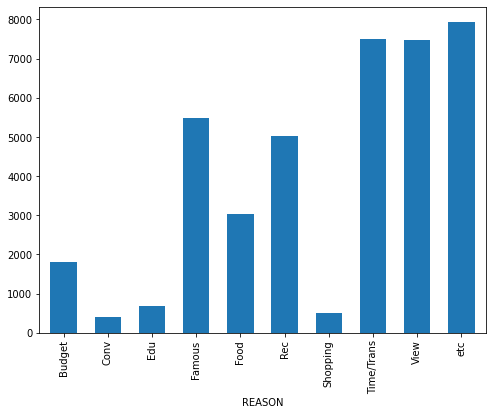

In [ ]:
#제주도 여행 이유
reason = pd.crosstab((df['SPOT']=='Jeju'), df['REASON'])
reason

plt.rcParams['figure.figsize'] = [8, 6]
ax = reason.iloc[0].plot.bar(width = 0.6, stacked=True)

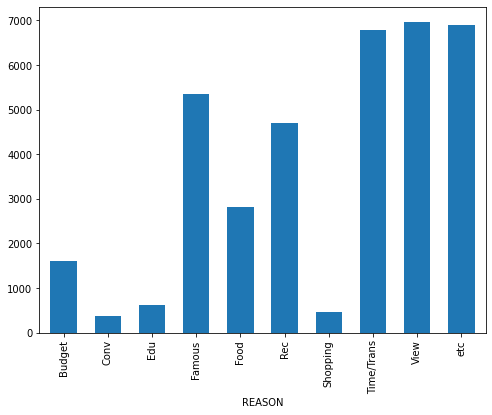

In [ ]:
#충남 여행 이유
reason = pd.crosstab((df['SPOT']=='CN/Dae'), df['REASON'])
reason

plt.rcParams['figure.figsize'] = [8, 6]
ax = reason.iloc[0].plot.bar(width = 0.6, stacked=True)

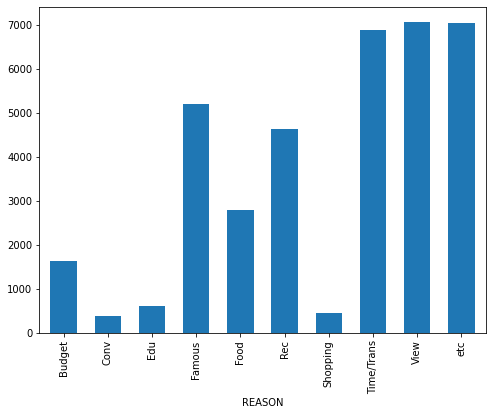

In [ ]:
#경북 여행 이유
reason = pd.crosstab((df['SPOT']=='KB/Dae'), df['REASON'])
reason

plt.rcParams['figure.figsize'] = [8, 6]
ax = reason.iloc[0].plot.bar(width = 0.6, stacked=True)

In [ ]:
!pip install -U pandas

Requirement already up-to-date: pandas in /usr/local/lib/python3.7/dist-packages (1.2.5)


In [ ]:
df_why=pd.crosstab(df['REASON'], df['SPOT'])
df_why.index.name = None
df_why

SPOT,Bu/Wul,CB,CN/Dae,Gangwon,Gyeongi,JB,JN/Gwa,Jeju,KB/Dae,KN,Seo/In
Budget,131,84,248,179,220,136,231,59,232,223,111
Conv,20,15,44,73,53,16,34,16,49,31,66
Edu,40,34,86,73,98,57,51,35,92,66,72
Famous,532,241,584,837,458,434,683,434,736,679,310
Food,287,90,338,372,226,342,563,115,363,307,151
Rec,412,223,594,639,486,382,710,260,646,562,369
Shopping,54,22,59,30,51,28,43,20,66,30,110
Time/Trans,555,348,995,904,1000,522,948,267,895,782,554
View,654,370,922,985,634,740,1056,411,825,772,514
etc,547,498,1220,500,1079,441,813,183,1081,646,1107


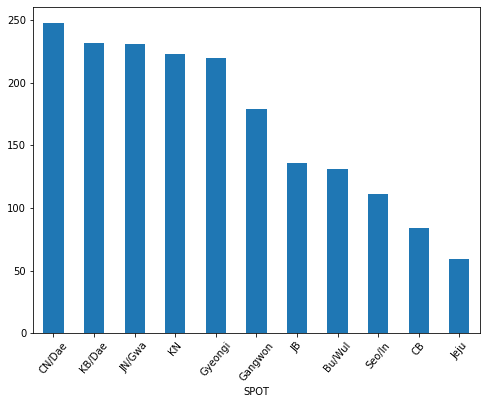

In [ ]:
#쇼핑하러가는 도시
df_why2=df_why.loc['Shopping', : ].sort_values(ascending=False)
# df_why3.head(5).plot(kind='pie');
df_why3.plot(kind='bar', rot=50);
#경남>경기도>전남>경북>충남

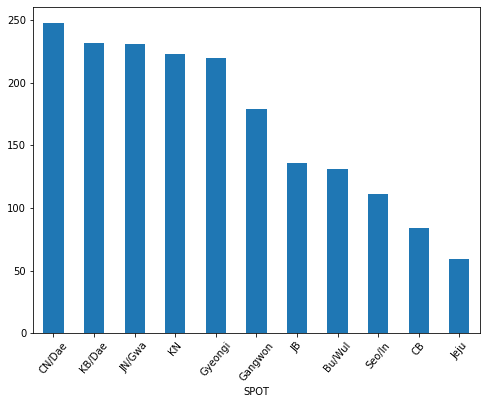

In [ ]:
#저렴해서 방문하는 도시
df_why3=df_why.loc['Budget', : ].sort_values(ascending=False)
# df_why3.head(5).plot(kind='pie');
df_why3.plot(kind='bar', rot=50);
#경남>경기도>전남>경북>충남

[Text(0.5, 0, 'Cost Category'), Text(0.5, 1.0, 'Visitor')]

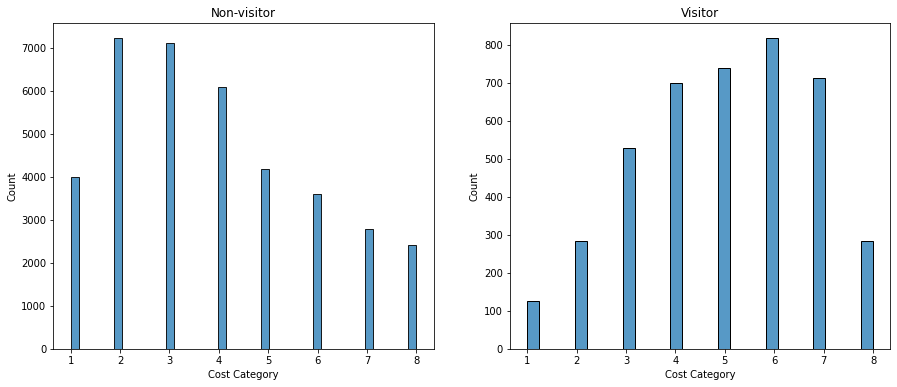

In [ ]:
# 강원도 방문 여부에 따른 사용액 범주
non_visit = df[df.Gangwon==False]['BNA']
visit = df[df.Gangwon==True]['BNA']


import seaborn as sns
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1, 2, figsize=(15,6))
sns.histplot(non_visit, ax=ax[0]);
sns.histplot(visit, ax=ax[1]);

ax[0].set(xlabel='Cost Category', title="Non-visitor")
ax[1].set(xlabel='Cost Category', title="Visitor")

In [ ]:
df.groupby('Gangwon')['ONE_TCOST'].agg(['count','mean','median','max','min'])
#강원도에 다녀온 사람의 평균 지출이 그렇지 않은 사람보다 높다.

,count,mean,median,max,min
Gangwon,,,,,
False,37431,128701.913268,94000.0,3500000.0,2500.0
True,4190,165765.443357,150000.0,2500000.0,3000.0


[Text(0.5, 0, 'Month'), Text(0.5, 1.0, 'Visitor')]

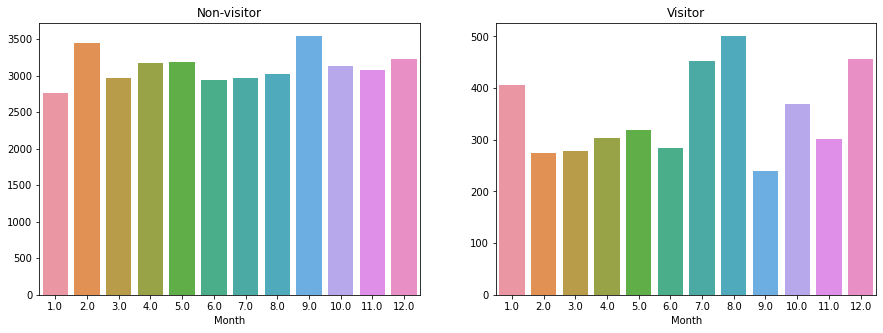

In [ ]:
#강원도에 가장 많이 가는 월
non_vmonth = df[df.Gangwon==False]['SMONTH'].value_counts()
vmonth = df[df.Gangwon==True]['SMONTH'].value_counts()

nvm = non_vmonth.sort_index()
vn = vmonth.sort_index()

fig, ax = plt.subplots(1,2,figsize=(15,5))
sns.barplot(x=nvm.index, y=nvm.values, ax=ax[0]);
sns.barplot(x=vn.index, y=vn.values, ax=ax[1]);

ax[0].set(xlabel='Month', title="Non-visitor")
ax[1].set(xlabel='Month', title="Visitor")

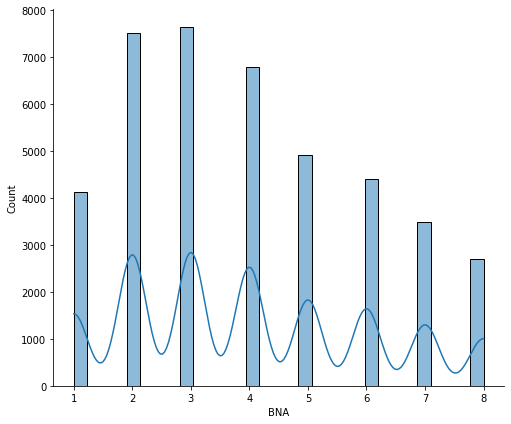

In [ ]:
sns.displot(data=df['BNA'].sort_values(), height=6, aspect=1.2, kde=True);

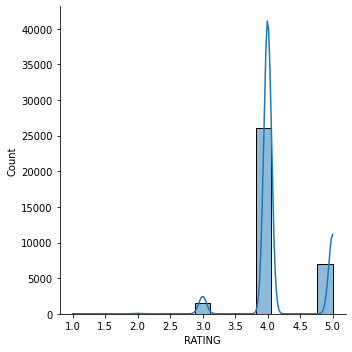

In [ ]:
#만족도는 응답자 편향이 너무 심해서 분석에 쓰기 어렵겠다...
sns.displot(df['RATING'],kde=True);
# plt.axvline(3.7, color='red');

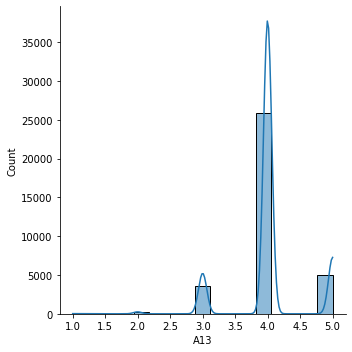

In [ ]:
#재방문의사
sns.displot(df['A13'],kde=True);

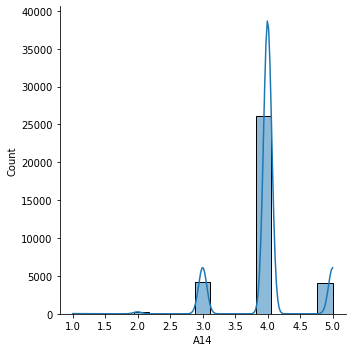

In [ ]:
#추천의도
sns.displot(df['A14'],kde=True);

# **3. 데이터 모델링**

## **3-1 모델링 데이터 engineering(mdf_essential)**

In [25]:
df.columns.unique()

Index(['ID', 'SMONTH', 'S_Day', 'TCOST', 'TNUM', 'ONE_TCOST', 'CASE', 'SPOT',
       'A2_1', 'A2_2', 'A2_3', 'A7B_1', 'A7B_2', 'A7B_3', 'A7B_4', 'A7B_5',
       'A7B_6', 'PRE_TOTAL', 'NA10A', 'NA10C', 'NA10D', 'NA10E', 'NA10F',
       'NA10G', 'NA_TOTAL', 'RATING', 'A13', 'A14', 'DQ5', 'DQ6', 'SEX',
       'BAGE', 'BARA', 'EXP_NIGHT', 'EXP_ADAY', 'A7B', 'M_TOTAL', 'BNA',
       'DandN', 'REASON', 'Gangwon'],
      dtype='object')

In [26]:
mdf=df[['SMONTH', 'S_Day', 'TNUM', 'A7B', 'DandN', 'REASON', 'M_TOTAL',
        'SEX', 'BAGE', 'Gangwon']]

In [27]:
mdf.shape

(41621, 10)

In [28]:
mdf['TNUM'].fillna(mdf['TNUM'].mean(), inplace=True)
mdf.isnull().sum()

/usr/local/lib/python3.7/dist-packages/pandas/core/series.py:4536: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  downcast=downcast,


SMONTH     0
S_Day      0
TNUM       0
A7B        0
DandN      0
REASON     0
M_TOTAL    0
SEX        0
BAGE       0
Gangwon    0
dtype: int64

In [29]:
mdf.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 41621 entries, 0 to 41623
Data columns (total 10 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   SMONTH   41621 non-null  float64
 1   S_Day    41621 non-null  float64
 2   TNUM     41621 non-null  float64
 3   A7B      41621 non-null  object 
 4   DandN    41621 non-null  int64  
 5   REASON   41621 non-null  object 
 6   M_TOTAL  41621 non-null  float64
 7   SEX      41621 non-null  int64  
 8   BAGE     41621 non-null  int64  
 9   Gangwon  41621 non-null  bool   
dtypes: bool(1), float64(4), int64(3), object(2)
memory usage: 3.2+ MB


In [30]:
mdf['SEX']=mdf['SEX'].astype(str)
mdf['BAGE']=mdf['BAGE'].astype(str)
mdf.head()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,SMONTH,S_Day,TNUM,A7B,DandN,REASON,M_TOTAL,SEX,BAGE,Gangwon
0,7.0,2.0,5.0,Mate,1,Time/Trans,360000.0,2,6,False
1,5.0,0.0,33.0,Crew,0,View,57200.0,2,5,False
2,5.0,0.0,5.0,Mate,0,etc,90000.0,1,7,False
3,5.0,2.0,5.0,Fam,1,Time/Trans,68500.0,2,6,False
4,9.0,1.0,5.0,Mate,1,View,100000.0,2,6,False


## **3-1 모델링 데이터 engineering(ndf_max)**

In [48]:
import numpy as np

ndf=df[['SMONTH', 'S_Day', 'TNUM', 'A7B', 'DandN', 'REASON',  
        'ONE_TCOST', 'NA10A', 'NA10C', 'NA10D', 'M_TOTAL', 
        'SEX', 'BAGE', 'Gangwon']]

ndf=ndf[(ndf['ONE_TCOST'] >= np.percentile(ndf['ONE_TCOST'], 0.5)) & 
        (ndf['ONE_TCOST'] <= np.percentile(ndf['ONE_TCOST'], 99.5)) &
        (ndf['M_TOTAL'] >= np.percentile(ndf['M_TOTAL'], 0.5)) & 
        (ndf['M_TOTAL'] <= np.percentile(ndf['M_TOTAL'], 99.5))]

ndf['TNUM'].fillna(ndf['TNUM'].mean(), inplace=True)
ndf['NA10A'].fillna(ndf['NA10A'].mean(), inplace=True)
ndf['NA10C'].fillna(ndf['NA10C'].mean(), inplace=True)

ndf.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 41238 entries, 0 to 41623
Data columns (total 14 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   SMONTH     41238 non-null  float64
 1   S_Day      41238 non-null  float64
 2   TNUM       41238 non-null  float64
 3   A7B        41238 non-null  object 
 4   DandN      41238 non-null  int64  
 5   REASON     41238 non-null  object 
 6   ONE_TCOST  41238 non-null  float64
 7   NA10A      41238 non-null  float64
 8   NA10C      41238 non-null  float64
 9   NA10D      34310 non-null  float64
 10  M_TOTAL    41238 non-null  float64
 11  SEX        41238 non-null  int64  
 12  BAGE       41238 non-null  int64  
 13  Gangwon    41238 non-null  bool   
dtypes: bool(1), float64(8), int64(3), object(2)
memory usage: 4.4+ MB


## **3-2 기준모델 _ Gangwon**


In [ ]:
from sklearn.model_selection import train_test_split
train, test = train_test_split(mdf, test_size=0.2, random_state=2)
train.shape, test.shape

((33296, 12), (8325, 12))

In [ ]:
target = 'Gangwon'
features = mdf.columns.drop([target, 'SPOT'])

X_train = train[features]
y_train = train[target]
X_test = test[features]
y_test = test[target]
X_train.columns

Index(['SMONTH', 'S_Day', 'TNUM', 'A7B', 'DandN', 'REASON', 'BNA', 'M_TOTAL',
       'SEX', 'BAGE'],
      dtype='object')

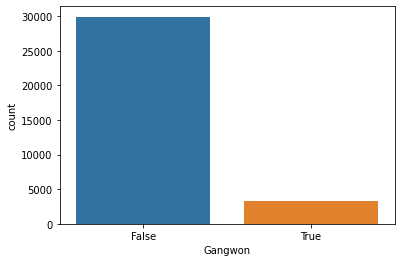

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
sns.countplot(x=y_train);

# 분류문제,  타겟 클래스비율이 70% 이상 차이나서 정확도 만으로는 판단할 수 없음
# 정밀도, 재현율, ROC curve, AUC 등을 같이 사용해야 함

In [ ]:
from sklearn.metrics import classification_report

#기준모델_최빈값
major = y_train.mode()[0]
y_pred = [major] * len(y_train)

from sklearn.metrics import accuracy_score
print("훈련 정확도: ", accuracy_score(y_train, y_pred))
print(classification_report(y_train, y_pred))

y_test = test[target]
y_pred = [major] * len(y_test)
print("검증 정확도: ", accuracy_score(y_test, y_pred))

훈련 정확도:  0.8990869774147044
              precision    recall  f1-score   support

       False       0.90      1.00      0.95     29936
        True       0.00      0.00      0.00      3360

    accuracy                           0.90     33296
   macro avg       0.45      0.50      0.47     33296
weighted avg       0.81      0.90      0.85     33296

검증 정확도:  0.9003003003003003


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


## (열지 마시오) 수치형 특성만 / 선형회귀모델 (열지 마시오)

In [ ]:
ndf.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 41621 entries, 0 to 41623
Data columns (total 17 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   SMONTH     41621 non-null  float64
 1   S_Day      41621 non-null  float64
 2   TNUM       41621 non-null  float64
 3   A7B        41621 non-null  object 
 4   DandN      41621 non-null  int64  
 5   REASON     41621 non-null  object 
 6   ONE_TCOST  41621 non-null  float64
 7   NA10A      41621 non-null  float64
 8   NA10C      41621 non-null  float64
 9   NA10D      41621 non-null  float64
 10  NA10E      41621 non-null  float64
 11  NA10F      41621 non-null  float64
 12  NA10G      41621 non-null  float64
 13  M_TOTAL    41621 non-null  float64
 14  SEX        41621 non-null  int64  
 15  BAGE       41621 non-null  int64  
 16  Gangwon    41621 non-null  bool   
dtypes: bool(1), float64(11), int64(3), object(2)
memory usage: 5.4+ MB


In [ ]:
from sklearn.linear_model import LinearRegression

linear_model = LinearRegression()

# 숫자형 특성
features = ['SMONTH', 'S_Day', 'TNUM', 'M_TOTAL']

from sklearn.model_selection import train_test_split
train2, test2 = train_test_split(ndf, test_size=0.2, random_state=2)
train2.shape, test2.shape

X_train = train2[features]
y_train = train2['Gangwon']
X_test = test2[features]
y_test = test2['Gangwon']


from sklearn.impute import SimpleImputer

imputer = SimpleImputer() 
X_train_imputed = imputer.fit_transform(X_train)
X_test_imputed = imputer.transform(X_test)

linear_model.fit(X_train_imputed, y_train)
pred = linear_model.predict(X_test_imputed)

In [ ]:
pd.Series(linear_model.coef_, features).sort_values(ascending=False)
#연말 / 장기 / 다수 / 고액 일수록 강원도에

S_Day      1.509358e-02
TNUM       2.411481e-03
SMONTH     2.052960e-03
M_TOTAL    1.589930e-07
dtype: float64

In [ ]:
#12월, 5일간, 5명이, 50만원
test_case = [[12, 5, 120, 10000000]]
linear_model.predict(test_case)

array([2.02845089])

In [ ]:
from sklearn.linear_model import LogisticRegression

logistic = LogisticRegression()
logistic.fit(X_train_imputed, y_train)

print('검증세트 정확도', logistic.score(X_test_imputed, y_test))

검증세트 정확도 0.9003003003003003


In [ ]:
pred = logistic.predict(X_test_imputed)
pred

logistic.predict(test_case)
#틀렸네..?

array([False])

## **3-3 파이프라인_홀드아웃 1**

In [ ]:
from sklearn.model_selection import train_test_split
train, test = train_test_split(mdf, test_size=0.2, random_state=2)
train.shape, test.shape

train, val = train_test_split(train, test_size=0.2, random_state=2)
train.shape, val.shape

target = 'Gangwon'
features = mdf.columns.drop([target, 'SPOT', 'BNA'])

X_train = train[features]
y_train = train[target]
X_val = val[features]
y_val = val[target]
X_test = test[features]
X_train.shape, X_val.shape, X_test.shape

((26636, 9), (6660, 9), (8325, 9))

In [ ]:
X_train.columns

Index(['SMONTH', 'S_Day', 'TNUM', 'A7B', 'DandN', 'REASON', 'M_TOTAL', 'SEX',
       'BAGE'],
      dtype='object')

In [ ]:
from sklearn.pipeline import make_pipeline
from category_encoders import TargetEncoder
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

pipe1 = make_pipeline(
    TargetEncoder(), 
    SimpleImputer(),
    RandomForestClassifier(n_estimators=50, random_state=2, n_jobs=-1)
)

pipe1.fit(X_train, y_train)
print('훈련 정확도: ', pipe1.score(X_train, y_train))
print('검증 정확도: ', pipe1.score(X_val, y_val))

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm
/usr/local/lib/python3.7/dist-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):


훈련 정확도:  0.9968088301546779
검증 정확도:  0.8884384384384384


Text(0.5, 1.0, 'Confusion matrix, n = 6660')

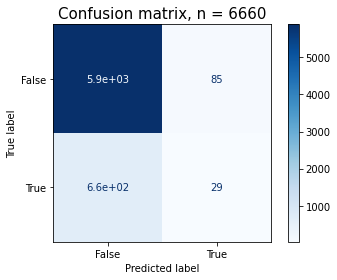

In [ ]:
# 타겟의 경우 진짜 강원도임을 찾는 정밀도(precision)가 중요하다

from sklearn.metrics import plot_confusion_matrix
import matplotlib.pyplot as plt

fig, ax = plt.subplots()
pcm = plot_confusion_matrix(pipe1, X_val, y_val,
                            cmap=plt.cm.Blues,
                            ax=ax);
plt.title(f'Confusion matrix, n = {len(y_val)}', fontsize=15)
#아닌게 실제로 많아서, 일단 아니라고 하면 아닐 확률이 높은 상태

## **3-3 파이프라인_홀드아웃 2**

In [ ]:
from sklearn.model_selection import train_test_split
train, test = train_test_split(mdf, test_size=0.2, random_state=2)
train.shape, test.shape

train, val = train_test_split(train, test_size=0.2, random_state=2)
train.shape, val.shape

target = 'Gangwon'
features = mdf.columns.drop([target])

X_train = train[features]
y_train = train[target]
X_val = val[features]
y_val = val[target]
X_test = test[features]
X_train.shape

(26636, 9)

In [ ]:
pipe2 = make_pipeline(
    OrdinalEncoder(), 
    SimpleImputer(), 
    StandardScaler(),
    RandomForestClassifier(max_depth=12, class_weight='balanced',
                           n_estimators=50, random_state=2, n_jobs=-1)
)

pipe2.fit(X_train, y_train)

print('훈련 정확도: ', pipe2.score(X_train, y_train))
print('검증 정확도: ', pipe2.score(X_val, y_val))

#True 범주의 수치
from sklearn.metrics import classification_report

y_pred = pipe2.predict(X_val)
print(classification_report(y_val, y_pred))

훈련 정확도:  0.80177203784352
검증 정확도:  0.7524024024024024
              precision    recall  f1-score   support

       False       0.94      0.78      0.85      5973
        True       0.22      0.54      0.31       687

    accuracy                           0.75      6660
   macro avg       0.58      0.66      0.58      6660
weighted avg       0.86      0.75      0.79      6660



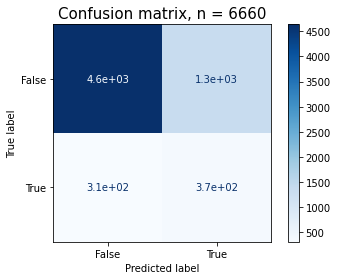

In [ ]:
from sklearn.metrics import plot_confusion_matrix
import matplotlib.pyplot as plt

fig, ax = plt.subplots()
pcm = plot_confusion_matrix(pipe2, X_val, y_val,
                            cmap=plt.cm.Blues,
                            ax=ax);
plt.title(f'Confusion matrix, n = {len(y_val)}', fontsize=15)
plt.show()

AUC score:  0.7451727826163881


Text(0, 0.5, 'TPR(Recall)')

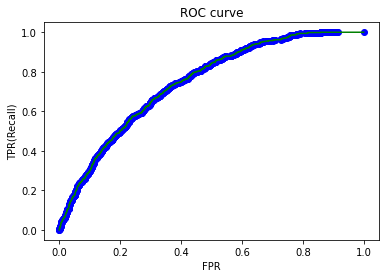

In [ ]:
from sklearn.metrics import roc_auc_score, roc_curve


y_pred_proba = pipe2.predict_proba(X_val)[:, -1]
print('AUC score: ', roc_auc_score(y_val, y_pred_proba))

fpr, tpr, thresholds = roc_curve(y_val, y_pred_proba)
plt.scatter(fpr, tpr, color='blue')
plt.plot(fpr, tpr, color='green')
plt.title('ROC curve')
plt.xlabel('FPR')
plt.ylabel('TPR(Recall)')

In [ ]:
#최적의 임계값
import numpy as np

optimal_idx = np.argmax(tpr - fpr)
optimal_threshold = thresholds[optimal_idx]

print('idx:', optimal_idx, ', threshold:', optimal_threshold)

y_pred_optimal = y_pred_proba >= optimal_threshold
print(classification_report(y_val, y_pred_optimal))

idx: 792 , threshold: 0.34323559800437775
              precision    recall  f1-score   support

       False       0.95      0.63      0.76      5973
        True       0.19      0.73      0.30       687

    accuracy                           0.64      6660
   macro avg       0.57      0.68      0.53      6660
weighted avg       0.87      0.64      0.71      6660



In [ ]:
from ipywidgets import interact, fixed

y_pred_proba = pipe2.predict_proba(X_val)[:, 1]
def explore_threshold(y_true, y_pred_proba, threshold=0.5):
    y_pred = y_pred_proba >= threshold
    vc = pd.Series(y_pred).value_counts()
    ax = sns.histplot(y_pred_proba, kde=True)
    ax.axvline(threshold, color='red')
    ax.set_title(f'# of target, 1={vc[1]}, 0={vc[0]}')
    plt.show()
    print(classification_report(y_true, y_pred))

    
interact(explore_threshold, 
    y_true=fixed(y_val), 
    y_pred_proba=fixed(y_pred_proba), 
    threshold=(0, 1, 0.01));

interactive(children=(FloatSlider(value=0.5, description='threshold', max=1.0, step=0.01), Output()), _dom_cla…

In [ ]:
#높을 수록 좋은 auc...
from sklearn.metrics import roc_auc_score
print('auc_score :', roc_auc_score(y_val, y_pred_proba))

auc_score : 0.7451727826163881


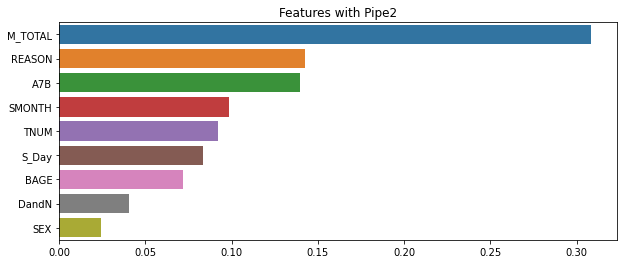

In [ ]:
import matplotlib.pyplot as plt

rf = pipe2.named_steps['randomforestclassifier']
importances = pd.Series(rf.feature_importances_, X_train.columns)
rf_top = importances.sort_values(ascending=False)

plt.figure(figsize=(10,4))
plt.title(f'Features with Pipe2')
sns.barplot(x=rf_top, y=rf_top.index)
plt.show()

## **3-3 파이프라인_홀드아웃 2(ndf)**

In [ ]:
from sklearn.model_selection import train_test_split
train2, test2 = train_test_split(ndf, test_size=0.2, random_state=2)

train2, val2 = train_test_split(train2, test_size=0.2, random_state=2)

target2 = 'Gangwon'
features2 = ndf.columns.drop([target])

X_train2 = train2[features2]
y_train2 = train2[target2]
X_val2 = val2[features2]
y_val2 = val2[target2]
X_test = test2[features2]
y_test2 = test2[target2]

In [ ]:
pipe2.fit(X_train2, y_train2)

print('훈련 정확도: ', pipe2.score(X_train2, y_train2))
print('검증 정확도: ', pipe2.score(X_val2, y_val2))

#True 범주의 수치
from sklearn.metrics import classification_report

y_pred2 = pipe2.predict(X_val2)
print(classification_report(y_val2, y_pred2))

훈련 정확도:  0.8288782099414327
검증 정확도:  0.7810810810810811
              precision    recall  f1-score   support

       False       0.94      0.81      0.87      5973
        True       0.25      0.55      0.34       687

    accuracy                           0.78      6660
   macro avg       0.59      0.68      0.61      6660
weighted avg       0.87      0.78      0.81      6660



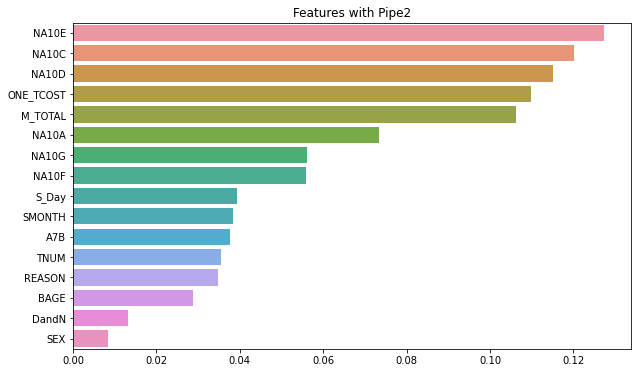

In [ ]:
import matplotlib.pyplot as plt

rf2 = pipe2.named_steps['randomforestclassifier']
importances2 = pd.Series(rf2.feature_importances_, X_train2.columns)
rf_top2 = importances2.sort_values(ascending=False)

plt.figure(figsize=(10,6))
plt.title(f'Features with Pipe2')
sns.barplot(x=rf_top2, y=rf_top2.index)
plt.show()

## **3-4 최적의 하이퍼파라미터 (XGBClassifier, RandomizedSearchCV)**

In [ ]:
target='Gangwon'
features = mdf.columns.drop([target, 'SPOT', 'M_TOTAL'])

from sklearn.model_selection import train_test_split
train, test = train_test_split(mdf, test_size=0.2, random_state=2)
train.shape, test.shape

X_train = train[features]
y_train = train[target]
X_test = test[features]
y_test = test[target]
X_train.shape, y_train.shape

((33296, 9), (33296,))

In [ ]:
y_train.value_counts(normalize=True)
ratio = 0.101/0.899

In [ ]:
#하이퍼파라미터 튜닝
from sklearn.feature_selection import f_regression, SelectKBest
from sklearn.model_selection import cross_val_score
from scipy.stats import randint, uniform
from sklearn.model_selection import RandomizedSearchCV
from xgboost import XGBClassifier

pipe = make_pipeline(
    TargetEncoder(smoothing=20), 
    SimpleImputer(strategy='mean'), 
    XGBClassifier(n_jod=-1, scale_pos_weight=ratio)
)

dists = {
    'targetencoder__min_samples_leaf': randint(5, 10),
    'xgbclassifier__n_estimators': randint(50, 100, 600), 
    'xgbclassifier__learning_rate': [1.5, 1.2, 0.7], 
    'xgbclassifier__max_depth': randint(3, 15)
}

clf = RandomizedSearchCV(
    pipe, 
    param_distributions=dists, 
    n_iter=50, 
    cv=3, 
    scoring='precision',  
    verbose=1,
    n_jobs=-1
)

clf.fit(X_train, y_train);

Fitting 3 folds for each of 50 candidates, totalling 150 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed: 11.2min
[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed: 35.9min finished
/usr/local/lib/python3.7/dist-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):


In [ ]:
print(f'Best score(precision): {clf.best_score_}')
print(f'Best model: {clf.best_params_}')

Best score(precision): 0.30534670008354214
Best model: {'simpleimputer__strategy': 'mean', 'targetencoder__min_samples_leaf': 9, 'targetencoder__smoothing': 20.0, 'xgbclassifier__learning_rate': 0.7, 'xgbclassifier__max_depth': 4, 'xgbclassifier__n_estimators': 684}


In [ ]:
pipe_f = clf.best_estimator_

train_pred = pipe_f.predict(X_train)
test_pred = pipe_f.predict(X_test)

print('훈련 정확도: ', accuracy_score(y_train, train_pred))
print('시험 정확도: ', accuracy_score(y_test, test_pred))

print('\nClassification Report:')
print(classification_report(y_test, test_pred))

훈련 정확도:  0.9017900048053821
시험 정확도:  0.9003003003003003

Classification Report:
              precision    recall  f1-score   support

       False       0.90      1.00      0.95      7495
        True       0.50      0.00      0.00       830

    accuracy                           0.90      8325
   macro avg       0.70      0.50      0.48      8325
weighted avg       0.86      0.90      0.85      8325



## **3-4 하이퍼파라미터 2 (ndf)**

In [ ]:
from sklearn.model_selection import train_test_split
n_train, n_test = train_test_split(ndf, test_size=0.2, random_state=2)

n_target = 'Gangwon'
n_features = ndf.columns.drop([target])

nx_train = n_train[n_features]
ny_train = n_train[n_target]
nx_test = n_test[n_features]
ny_test = n_test[n_target]

In [ ]:
#하이퍼파라미터 튜닝
from sklearn.feature_selection import f_regression, SelectKBest
from sklearn.model_selection import cross_val_score
from scipy.stats import randint, uniform
from sklearn.model_selection import RandomizedSearchCV
from xgboost import XGBClassifier

pipe = make_pipeline(
    TargetEncoder(smoothing=20, min_samples_leaf=9), 
    SimpleImputer(strategy='mean'), 
    XGBClassifier(n_jod=-1, scale_pos_weight=ratio)
)

dists = {
    'xgbclassifier__n_estimators': randint(50, 100, 600), 
    'xgbclassifier__learning_rate': [1.5, 1.0, 0.7], 
    'xgbclassifier__max_depth': randint(3, 15)
}

clf2 = RandomizedSearchCV(
    pipe, 
    param_distributions=dists, 
    n_iter=50, 
    cv=3, 
    scoring='precision',  
    verbose=1,
    n_jobs=-1
)

clf2.fit(X_train, y_train);

Fitting 3 folds for each of 50 candidates, totalling 150 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed: 12.2min
[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed: 39.2min finished


In [ ]:
pipe_n = clf2.best_estimator_

train_pred = pipe_n.predict(X_train)
test_pred = pipe_n.predict(X_test)

print('훈련 정확도: ', accuracy_score(y_train, train_pred))
print('시험 정확도: ', accuracy_score(y_test, test_pred))

print('\nClassification Report:')
print(classification_report(y_test, test_pred))

훈련 정확도:  0.9097462081393602
시험 정확도:  0.8992192192192192

Classification Report:
              precision    recall  f1-score   support

       False       0.90      1.00      0.95      7495
        True       0.38      0.02      0.03       830

    accuracy                           0.90      8325
   macro avg       0.64      0.51      0.49      8325
weighted avg       0.85      0.90      0.86      8325



## **3-3 파이프라인_홀드아웃 3**

In [ ]:
from xgboost import XGBClassifier

pipe = make_pipeline(
    OrdinalEncoder(),
    SimpleImputer(strategy='median'),
    XGBClassifier(n_estimators=200
                  , random_state=2
                  , n_jobs=-1
                  , max_depth=7
                  , learning_rate=0.2
                 )
)

pipe.fit(X_train, y_train);

# **4. 모델링 결과 분석**

## **4-1. 홀드아웃2 순열중요도**

In [ ]:
from sklearn.pipeline import Pipeline
from category_encoders import OrdinalEncoder
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier


pipe = Pipeline([
    ('preprocessing', make_pipeline(OrdinalEncoder(), SimpleImputer())),
    ('rf', RandomForestClassifier(max_depth=12, class_weight='balanced', n_estimators=50, random_state=2, n_jobs=-1)) 
])

pipe.fit(X_train, y_train)

Pipeline(memory=None,
         steps=[('preprocessing',
                 Pipeline(memory=None,
                          steps=[('ordinalencoder',
                                  OrdinalEncoder(cols=['A7B', 'REASON', 'SEX',
                                                       'BAGE'],
                                                 drop_invariant=False,
                                                 handle_missing='value',
                                                 handle_unknown='value',
                                                 mapping=[{'col': 'A7B',
                                                           'data_type': dtype('O'),
                                                           'mapping': Mate     1
Fam      2
Etc      3
Crew     4
B_Fam    5
NaN     -2
dtype: int64},
                                                          {'col': 'REASON',
                                                           'data_type': dtype('O'),
                         

In [ ]:
import eli5
from eli5.sklearn import PermutationImportance

permuter = PermutationImportance(
    pipe.named_steps['rf'],
    scoring='precision',
    n_iter=5,
    random_state=2)

X_val_transformed = pipe.named_steps['preprocessing'].transform(X_val)
permuter.fit(X_val_transformed, y_val);

feature_names = X_val.columns.tolist()

eli5.show_weights(
    permuter, 
    top=None,
    feature_names=feature_names
)

Weight,Feature
0.0466 ± 0.0060,M_TOTAL
0.0208 ± 0.0167,S_Day
0.0208 ± 0.0085,A7B
0.0008 ± 0.0043,REASON
-0.0003 ± 0.0021,SEX
-0.0009 ± 0.0058,TNUM
-0.0014 ± 0.0041,SMONTH
-0.0025 ± 0.0050,BAGE
-0.0072 ± 0.0043,DandN


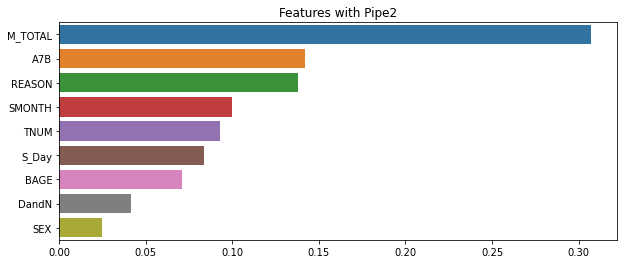

In [ ]:
#특성중요도
import matplotlib.pyplot as plt
import seaborn as sns

rf = pipe.named_steps['rf']
importances = pd.Series(rf.feature_importances_, X_train.columns)
rf_top = importances.sort_values(ascending=False)

plt.figure(figsize=(10,4))
plt.title(f'Features with Pipe2')
sns.barplot(x=rf_top, y=rf_top.index)
plt.show()

## **4-1. 홀드아웃2 부분의존그림 2(PDP)**

In [ ]:
mdf.head()

,SMONTH,S_Day,TNUM,A7B,DandN,REASON,M_TOTAL,SEX,BAGE,Gangwon
0,7.0,2.0,5.0,Mate,1,Time/Trans,360000.0,2,6,False
1,5.0,0.0,33.0,Crew,0,View,57200.0,2,5,False
2,5.0,0.0,5.0,Mate,0,etc,90000.0,1,7,False
3,5.0,2.0,5.0,Fam,1,Time/Trans,68500.0,2,6,False
4,9.0,1.0,5.0,Mate,1,View,100000.0,2,6,False


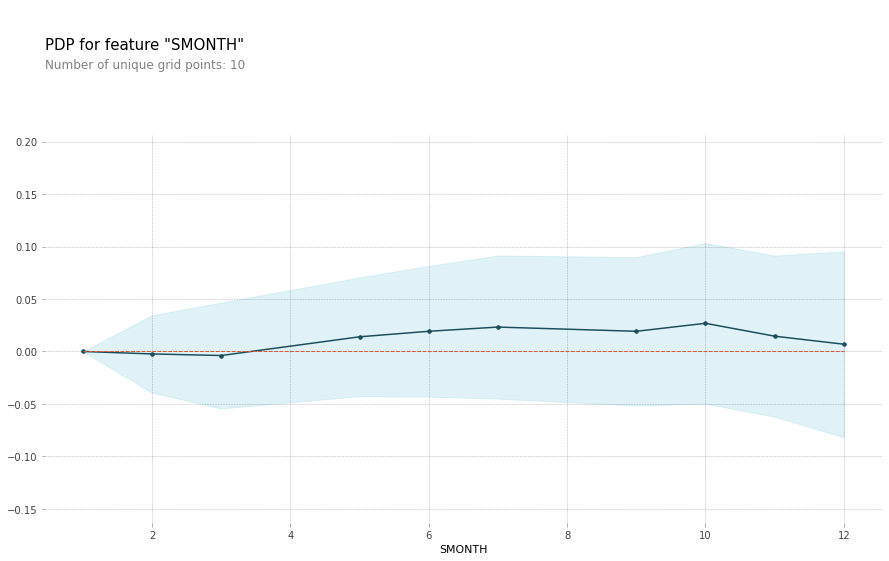

In [ ]:
from pdpbox.pdp import pdp_isolate, pdp_plot
from pdpbox import pdp

selected_feature = 'SMONTH'

pdp_dist = pdp_isolate(
    model=pipe, 
    dataset=X_val, 
    model_features=X_val.columns, 
    feature=selected_feature
)

pdp.pdp_plot(pdp_dist, selected_feature);

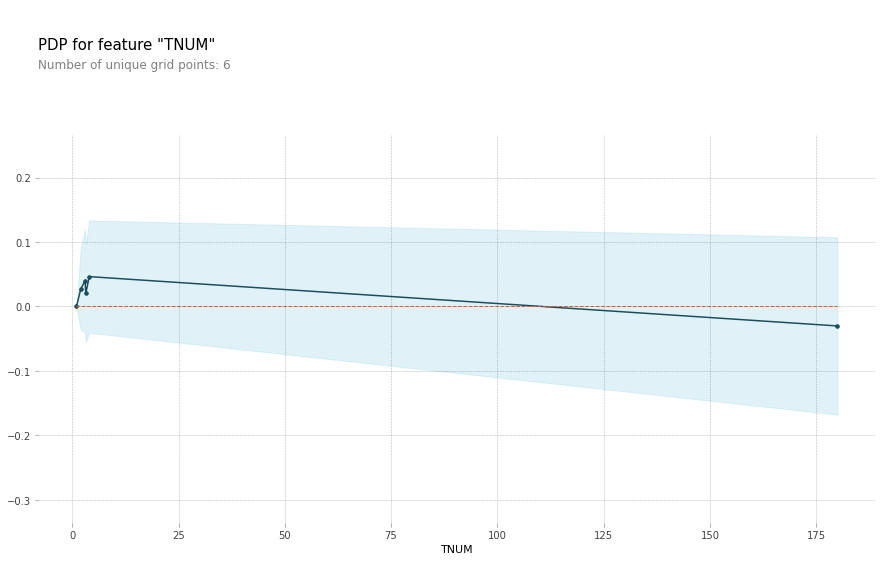

In [ ]:
selected_feature = 'TNUM'

pdp_dist = pdp_isolate(
    model=pipe, 
    dataset=X_val, 
    model_features=X_val.columns, 
    feature=selected_feature
)

pdp.pdp_plot(pdp_dist, selected_feature);

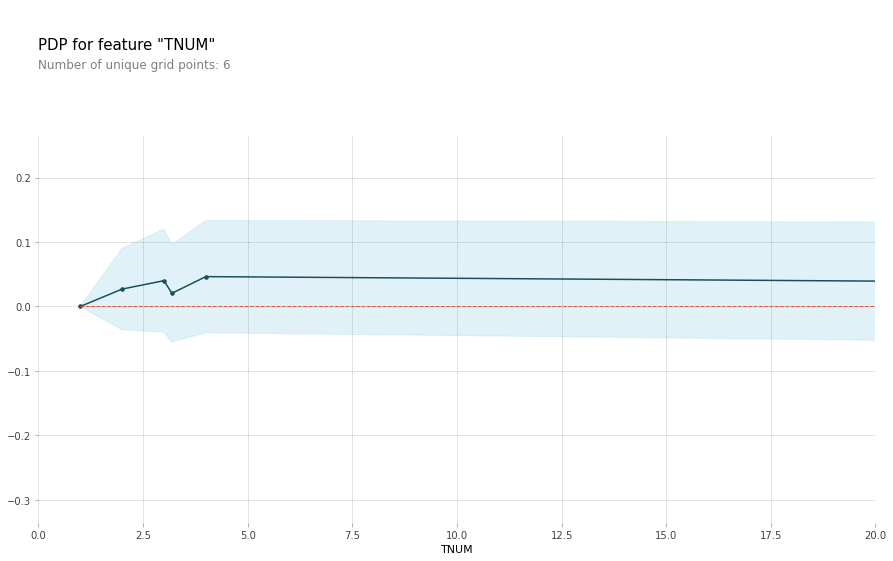

In [ ]:
pdp.pdp_plot(pdp_dist, selected_feature);
plt.xlim((0, 20));

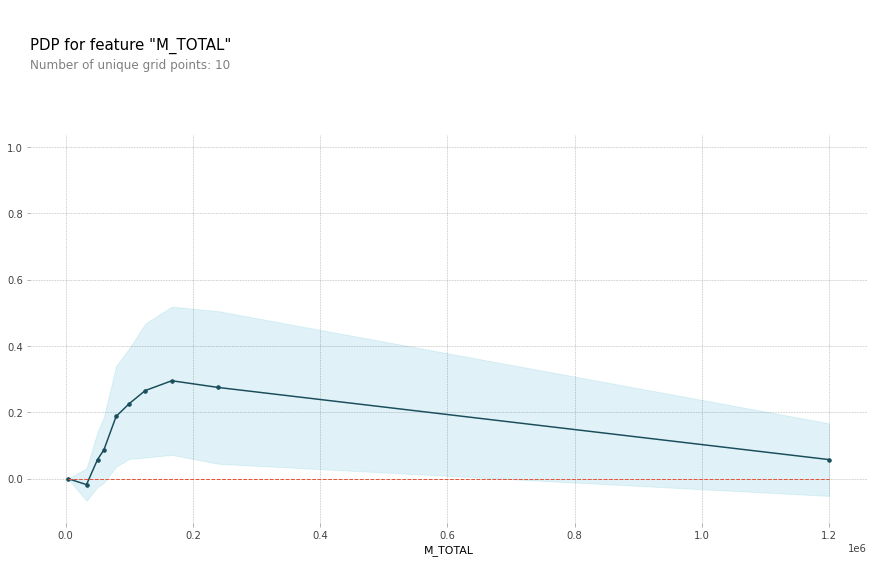

In [ ]:
selected_feature = 'M_TOTAL'

pdp_dist = pdp_isolate(
    model=pipe, 
    dataset=X_val, 
    model_features=X_val.columns, 
    feature=selected_feature
)

pdp.pdp_plot(pdp_dist, selected_feature);

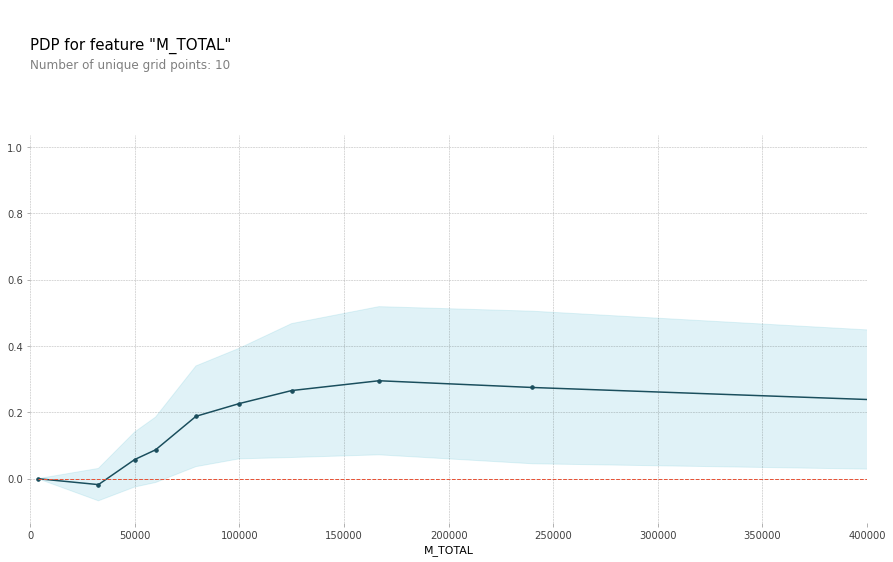

In [ ]:
pdp.pdp_plot(pdp_dist, selected_feature);
plt.xlim((0, 400000));

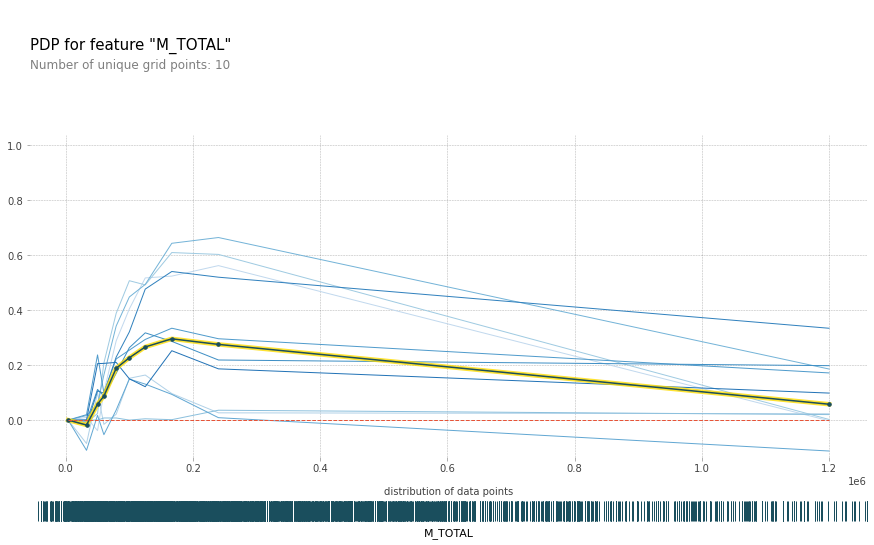

In [ ]:
pdp_plot(pdp_dist
         , feature_name= selected_feature
         , plot_lines=True 
         , frac_to_plot=10
         , plot_pts_dist=True) 
plt.xlim((0, 400000));

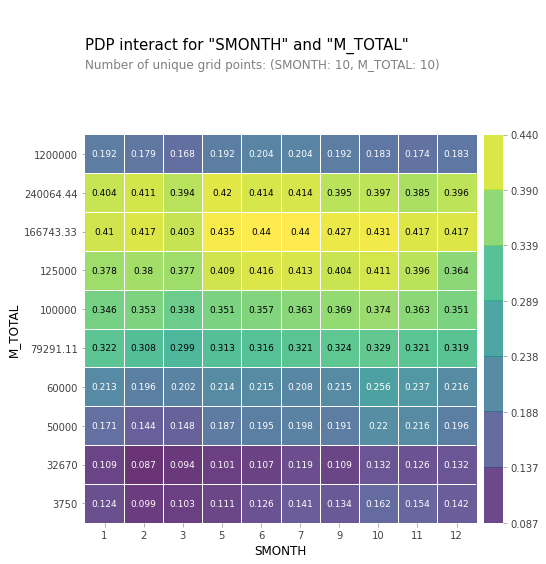

In [ ]:
from pdpbox.pdp import pdp_interact, pdp_interact_plot

interaction = pdp_interact(
    model=pipe, 
    dataset=X_val,
    model_features=X_val.columns
)

pdp_interact_plot(interaction, plot_type='grid', feature_names=['SMONTH', 'M_TOTAL']);

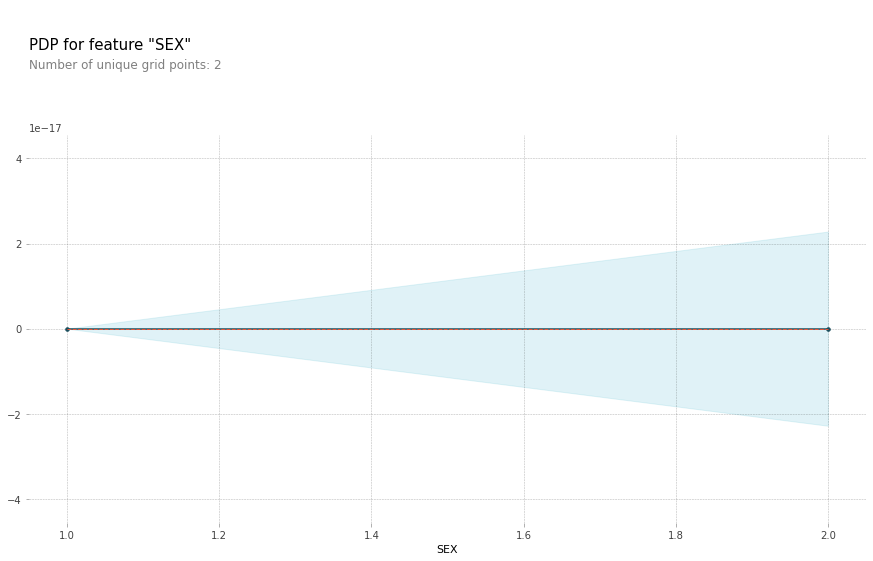

In [ ]:
import matplotlib.pyplot as plt
from pdpbox import pdp

X = mdf[features]
y = mdf[target]

encoder = pipe2.named_steps['ordinalencoder']
X_encoded = encoder.fit_transform(X)
rf = pipe2.named_steps['randomforestclassifier']

pdp_dist = pdp.pdp_isolate(model=pipe2, dataset=X_encoded, model_features=features, feature='SEX')
pdp.pdp_plot(pdp_dist, 'SEX');

In [ ]:
encoder.mapping

[{'col': 'A7B', 'data_type': dtype('O'), 'mapping': Mate     1
  Fam      2
  Etc      3
  Crew     4
  B_Fam    5
  NaN     -2
  dtype: int64},
 {'col': 'REASON', 'data_type': dtype('O'), 'mapping': View           1
  Famous         2
  etc            3
  Time/Trans     4
  Food           5
  Conv           6
  Rec            7
  Shopping       8
  Budget         9
  Edu           10
  NaN           -2
  dtype: int64},
 {'col': 'SEX', 'data_type': dtype('O'), 'mapping': 2      1
  1      2
  NaN   -2
  dtype: int64},
 {'col': 'BAGE', 'data_type': dtype('O'), 'mapping': 2      1
  4      2
  3      3
  5      4
  1      5
  6      6
  7      7
  NaN   -2
  dtype: int64}]

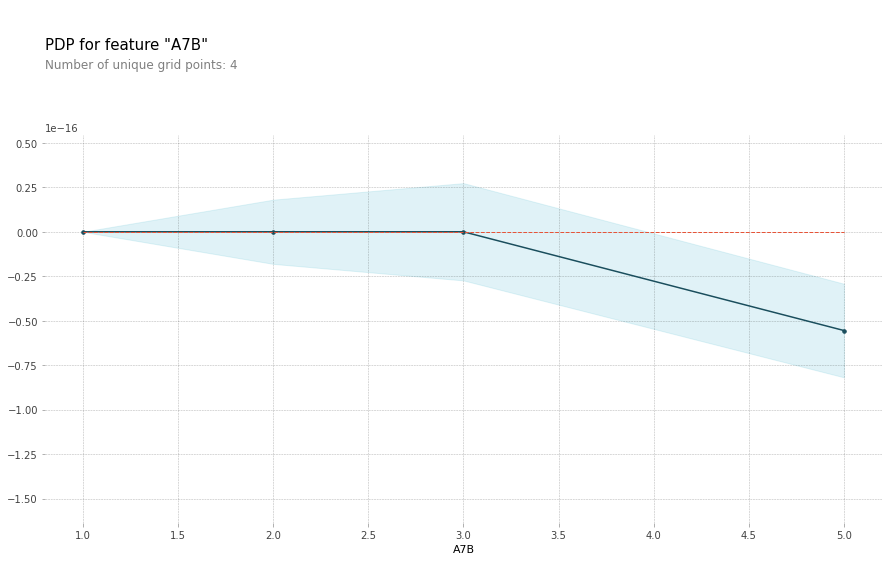

In [ ]:
pdp_dist = pdp.pdp_isolate(model=pipe2, dataset=X_encoded, model_features=features, feature='A7B')
pdp.pdp_plot(pdp_dist, 'A7B');

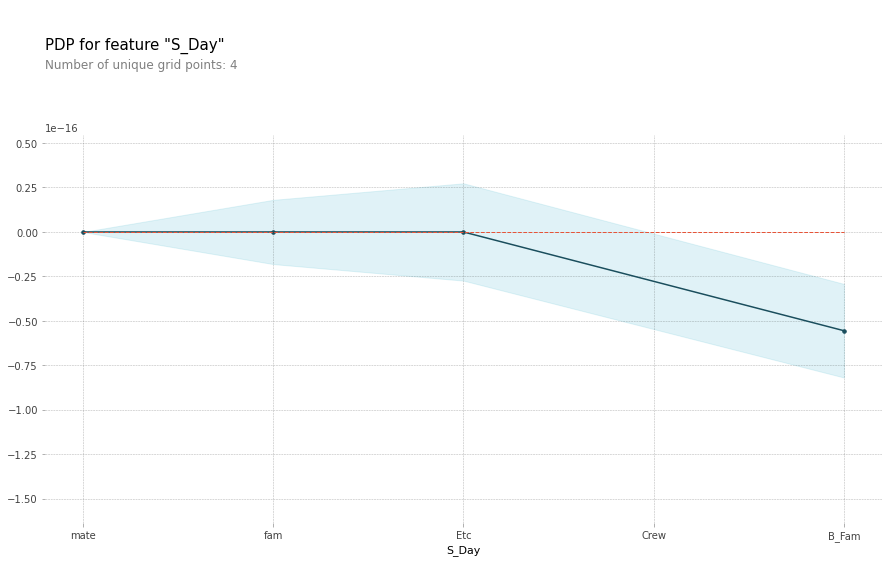

In [ ]:
pdp.pdp_plot(pdp_dist, feature)
plt.xticks([1, 2, 3, 4, 5], ['mate', 'fam', 'Etc', 'Crew', 'B_Fam']);

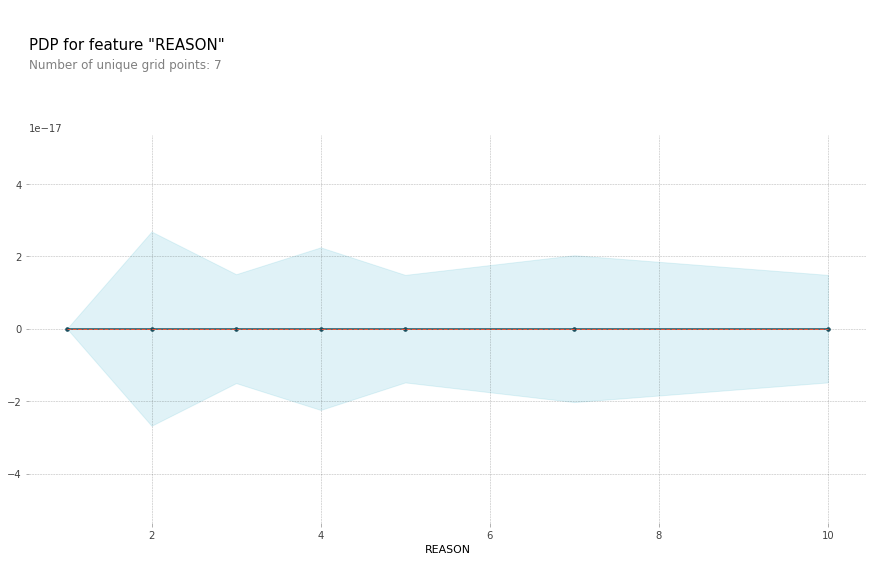

In [ ]:
pdp_dist = pdp.pdp_isolate(model=pipe2, dataset=X_encoded, model_features=features, feature='REASON')
pdp.pdp_plot(pdp_dist, 'REASON');

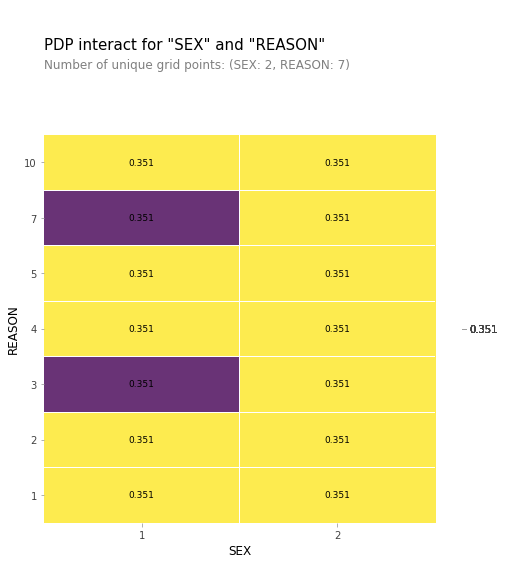

In [ ]:
features = ['SEX', 'REASON']

interaction = pdp_interact(
    model=pipe2, 
    dataset=X_encoded, 
    model_features=X_encoded.columns, 
    features=features
)

pdp_interact_plot(interaction, plot_type='grid', feature_names=features);

## **4-2 SHAP**

In [50]:
ndf.head()

,SMONTH,S_Day,TNUM,A7B,DandN,REASON,ONE_TCOST,NA10A,NA10C,NA10D,M_TOTAL,SEX,BAGE,Gangwon
0,7.0,2.0,5.0,Mate,1,Time/Trans,360000.0,0.0,55214.723926,123680.981595,360000.0,2,6,False
1,5.0,0.0,33.0,Crew,0,View,57200.0,0.0,0.000000,4200.000000,57200.0,2,5,False
2,5.0,0.0,5.0,Mate,0,etc,90000.0,0.0,0.000000,51373.390558,90000.0,1,7,False
3,5.0,2.0,5.0,Fam,1,Time/Trans,68500.0,0.0,0.000000,44500.000000,68500.0,2,6,False
4,9.0,1.0,5.0,Mate,1,View,100000.0,0.0,7029.876977,24428.822496,100000.0,2,6,False


In [75]:
target = 'Gangwon'
feature = ndf.columns.drop([target])

from sklearn.model_selection import train_test_split
train, test = train_test_split(ndf, test_size=0.2, random_state=2)
train, val = train_test_split(train, test_size=0.2, random_state=2)
train.shape, val.shape, test.shape

X_train = train[feature]
y_train=train[target]
X_val=val[feature]
y_val=val[target]
X_test = test[feature]
y_test = test[target]

In [68]:
y_train.value_counts(normalize=True)
ratio = 0.10/0.89

In [73]:
from sklearn.pipeline import make_pipeline
from category_encoders import OrdinalEncoder
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

processor = make_pipeline(
    OrdinalEncoder(), 
    SimpleImputer(), 
    StandardScaler())

X_train_processed = processor.fit_transform(X_train)
X_val_processed = processor.transform(X_val)

eval_set = [(X_train_processed, y_train), (X_val_processed, y_val)]

model = XGBClassifier(n_estimators=1000, verbosity=0, n_jobs=-1, scale_pos_weight=ratio)
model.fit(X_train_processed, y_train, eval_set=eval_set, eval_metric='auc', 
          early_stopping_rounds=10)

[0]	validation_0-auc:0.663837	validation_1-auc:0.676209
Multiple eval metrics have been passed: 'validation_1-auc' will be used for early stopping.

Will train until validation_1-auc hasn't improved in 10 rounds.
[1]	validation_0-auc:0.663837	validation_1-auc:0.676209
[2]	validation_0-auc:0.663837	validation_1-auc:0.676209
[3]	validation_0-auc:0.663837	validation_1-auc:0.676209
[4]	validation_0-auc:0.663837	validation_1-auc:0.676209
[5]	validation_0-auc:0.663837	validation_1-auc:0.676209
[6]	validation_0-auc:0.663837	validation_1-auc:0.676209
[7]	validation_0-auc:0.663837	validation_1-auc:0.676209
[8]	validation_0-auc:0.704689	validation_1-auc:0.715858
[9]	validation_0-auc:0.715135	validation_1-auc:0.724571
[10]	validation_0-auc:0.715135	validation_1-auc:0.724571
[11]	validation_0-auc:0.715135	validation_1-auc:0.724571
[12]	validation_0-auc:0.715135	validation_1-auc:0.724571
[13]	validation_0-auc:0.737753	validation_1-auc:0.745792
[14]	validation_0-auc:0.742028	validation_1-auc:0.74892

XGBClassifier(n_estimators=1000, n_jobs=-1,
              scale_pos_weight=0.11235955056179776, verbosity=0)

In [76]:
import xgboost
import shap

row = X_test.iloc[[3160]]

explainer = shap.TreeExplainer(model)
row_processed = processor.transform(row)
shap_values = explainer.shap_values(row_processed)

shap.initjs()
shap.force_plot(
    base_value=explainer.expected_value, 
    shap_values=shap_values, 
    features=row, 
    link='logit')

In [77]:
def explain(row_number):
    positive_class = 'True'
    positive_class_index = 1

    row = X_test.iloc[[row_number]]
    row_processed = processor.transform(row)

    pred = model.predict(row_processed)[0]
    pred_proba = model.predict_proba(row_processed)[0, positive_class_index]
    pred_proba *= 100
    if pred != positive_class:
        pred_proba = 100 - pred_proba

    print(f'예측결과는 {pred} 으로, 확률은 {pred_proba:.0f}% 입니다.')
    
    shap_values = explainer.shap_values(row_processed)

    feature_names = row.columns
    feature_values = row.values[0]
    shaps = pd.Series(shap_values[0], zip(feature_names, feature_values))
    pros = shaps.sort_values(ascending=False)[:3].index
    cons = shaps.sort_values(ascending=True)[:3].index

    print('\n')
    print('Positive 영향을 가장 많이 주는 3가지 요인 입니다:')
    
    evidence = pros if pred == positive_class else cons
    for i, info in enumerate(evidence, start=1):
        feature_name, feature_value = info
        print(f'{i}. {feature_name} : {feature_value}')

    print('\n')
    print('Negative 영향을 가장 많이 주는 3가지 요인 입니다:')
    
    evidence = cons if pred == positive_class else pros
    for i, info in enumerate(evidence, start=1):
        feature_name, feature_value = info
        print(f'{i}. {feature_name} : {feature_value}')

    # SHAP
    shap.initjs()
    return shap.force_plot(
        base_value=explainer.expected_value, 
        shap_values=shap_values, 
        features=row, 
        link='logit'
    )

In [80]:
explain(107)

예측결과는 False 으로, 확률은 97% 입니다.


Positive 영향을 가장 많이 주는 3가지 요인 입니다:
1. SMONTH : 3.0
2. NA10D : 40000.0
3. DandN : 1


Negative 영향을 가장 많이 주는 3가지 요인 입니다:
1. NA10C : 29999.999999999993
2. ONE_TCOST : 300000.0
3. REASON : Famous


In [81]:
explain(5525)

예측결과는 False 으로, 확률은 98% 입니다.


Positive 영향을 가장 많이 주는 3가지 요인 입니다:
1. ONE_TCOST : 53400.0
2. TNUM : 1.0
3. S_Day : 0.0


Negative 영향을 가장 많이 주는 3가지 요인 입니다:
1. NA10D : 0.0
2. A7B : Etc
3. NA10A : 0.0
